In [2]:
import os
import numpy as np
from tqdm.notebook import tqdm
%config InlineBackend.figure_format = 'svg'
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
from pdb import set_trace as bp

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amsfonts}']}
plt.rcParams.update(params)

# import torch
# torch.cuda.set_device(3)

import scipy.stats as stats
import json

/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
import os
import sys
from copy import deepcopy
from pathlib import Path
from collections import OrderedDict
from easydict import EasyDict as edict
import numpy as np
from numpy import linalg as LA
import shutil
import math
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
# from image_similarity_measures.quality_metrics import ssim

lib_dir = (Path("lib")).resolve()
if str(lib_dir) not in sys.path:
    sys.path.insert(0, str(lib_dir))

from models import get_search_spaces, CellStructure, get_cell_based_tiny_net, TinyNetwork

In [99]:
import sys
from graphviz import Digraph

def plot_201(arch, filename):
    g = Digraph(
            format='pdf',
            edge_attr=dict(fontsize='20', fontname="times"),
            node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
            engine='dot')

    node_idx2str = {
        0: "node_0\n(input)",
        1: "node_1",
        2: "node_2",
        3: "node_3\n(output)"
    }
    g.node(node_idx2str[0], fillcolor='lightblue')
    g.node(node_idx2str[1], fillcolor='darkseagreen2')
    g.node(node_idx2str[2], fillcolor='darkseagreen2')
    g.node(node_idx2str[3], fillcolor='palegoldenrod')

    for i, edges in enumerate(arch.nodes):
        for edge, node_idx in edges:
            g.edge(node_idx2str[node_idx], node_idx2str[i+1], label=edge, fillcolor="gray")

    return g


# plot darts
def plot_darts(genotype, filename=None):
    g = Digraph(
            format='pdf',
            edge_attr=dict(fontsize='20', fontname="times"),
            node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
            engine='dot')
    g.body.extend(['rankdir=LR'])

#     g.node("c_{k-2}", fillcolor='darkseagreen2')
#     g.node("c_{k-1}", fillcolor='darkseagreen2')
    g.node("node_0\n(input)", fillcolor='darkseagreen2')
    g.node("node_1\n(input)", fillcolor='darkseagreen2')
    assert len(genotype) % 2 == 0
    steps = len(genotype) // 2

    for i in range(steps):
#         g.node(str(i), fillcolor='lightblue')
        g.node("node_"+str(i+2), fillcolor='lightblue')

    for i in range(steps):
        for k in [2*i, 2*i + 1]:
            op, j = genotype[k]
            if j == 0:
#                 u = "c_{k-2}"
                u = "node_0\n(input)"
            elif j == 1:
#                 u = "c_{k-1}"
                u = "node_1\n(input)"
            else:
#                 u = str(j-2)
                u = "node_"+str(j)
#             v = str(i)
            v = "node_"+str(i+2)
            g.edge(u, v, label=op, fillcolor="gray")

#     g.node("c_{k}", fillcolor='palegoldenrod')
    g.node("node_6\n(output)", fillcolor='palegoldenrod')
    for i in range(steps):
#         g.edge(str(i), "c_{k}", fillcolor="gray")
        g.edge("node_"+str(i+2), "node_6\n(output)", fillcolor="gray")

    g.render(filename, view=True)

In [ ]:
def effective_depth_width_201(arch):
    edges = arch.split('+')
    edges = [edge[1:-1].split("|") for edge in edges]
    edge1 = '+'.join([edges[0][0], edges[1][1], edges[2][2]])
    edge2 = '+'.join([edges[0][0], edges[2][1]])
    edge3 = '+'.join([edges[1][0], edges[2][2]])
    edge4 = '+'.join([edges[2][0]])
    depths = []
    width = 0
    for edge in [edge1, edge2, edge3, edge4]:
        if "none" in edge: continue
        if "nor_conv" in edge: width += 1
        depths.append(edge.count("nor_conv"))
    if len(depths) == 0:
        return 0, 0, 0
    else:
        return np.mean(depths), width, width / np.mean(depths) if np.mean(depths) > 0 else 0

In [107]:
def clustering_coef(arch):
    depth = effective_depth_width_201(arch)[0]
    if depth == 0: return 0, 0
    edges = arch.split('+')
    edges = [edge[1:-1].split("|") for edge in edges]
    # edges connected to each intermediate node (both in- & out- degree)
    cluster1 = '+'.join([edges[0][0], edges[1][1], edges[2][1]])
    cluster2 = '+'.join([edges[1][0], edges[1][1], edges[2][2]])
    cluster3 = '+'.join([edges[2][0], edges[2][1], edges[2][2]])
    # parameterized edges on each node
    coef1 = cluster1.count("nor_conv") - cluster1.count("none")
    coef2 = cluster2.count("nor_conv") - cluster2.count("none")
    coef3 = cluster3.count("nor_conv") - cluster3.count("none")
    return np.mean([coef1, coef2, coef3]), np.std([coef1, coef2, coef3])

In [104]:
def find_all_paths(Aff, all_paths, curr_path=[], curr_pos=0, end_pos=5):
    if curr_pos == end_pos:
        all_paths.append(list(curr_path))
        return

    next_nodes = np.where(Aff[curr_pos, (curr_pos+1):] >= 0)[0] + curr_pos + 1
    for node in next_nodes:
        curr_path.append(Aff[curr_pos, node])
        find_all_paths(Aff, all_paths, curr_path, node, end_pos)
        curr_path.pop(-1)
    return all_paths


def effective_depth_width(Aff):
    Aff0 = np.array(Aff)
    Aff0 = np.delete(Aff0, 1, 0)
    Aff0 = np.delete(Aff0, 1, 1)
    paths0 = find_all_paths(Aff0, [])
    paths1 = find_all_paths(Aff[1:, 1:], [])
    paths = paths0 + paths1
    depth = 0
    width = 0
    for path in paths:
        depth += np.sum(path)
        width += int(np.sum(path) > 0)
    if depth == 0: return 0, 0
    else:
        depth = depth / len(paths)
        return depth, width/depth

In [696]:
def find_all_paths_3d_prob(Aff, all_paths, curr_path=[], curr_prob=1., curr_pos=0, end_pos=5):
    """
    Aff: from * to * (-1, 0, 1)
    end_post is 5 not 6: we start from node0 and node1 individually
    """
    if curr_pos == end_pos:
        all_paths.append([list(curr_path), curr_prob])
        return

    next_nodes = np.where(Aff[curr_pos, (curr_pos+1):, 0] < 1)[0] + curr_pos + 1
#     print(curr_pos, next_nodes)
    for node in next_nodes:
        for v_idx in range(1, 3):
            if Aff[curr_pos, node, v_idx] > 0:
                # curr_path.append(v_idx-1) # v_idx to edge value: 0: -1, 1: 0, 2: 1
                find_all_paths_3d_prob(Aff, all_paths, curr_path+[v_idx-1],
                                       curr_prob*Aff[curr_pos, node, v_idx]/len(next_nodes),
                                       node, end_pos)
                # curr_path.pop(-1)
    return all_paths


def mask_aff_edge(Aff, mask):
    Aff[mask[0], 3] = [-1, 0, 0]
    for from_node in mask[1]:
        Aff[from_node, 4] = [-1, 0, 0]
    for from_node in mask[2]:
        Aff[from_node, 5] = [-1, 0, 0]
    return Aff


def effective_depth_width_3d_prob(Aff, mask_groups):
    depth_all = 0; width_all = 0
    depth_width_probs = []
    num_groups = 0
    for group0 in mask_groups[0]:
        for group1 in mask_groups[1]:
            for group2 in mask_groups[2]:
                mask = [group0, group1, group2]; num_groups += 1
                # print(mask)
                Aff_masked = np.array(Aff)
                Aff_masked = mask_aff_edge(Aff_masked, mask)
                #############
                Aff0 = np.array(Aff_masked)
                Aff0 = np.delete(Aff0, 1, 0)
                Aff0 = np.delete(Aff0, 1, 1)
                # all possible unique end2end paths
                _paths0 = find_all_paths_3d_prob(Aff0, [])
                _paths1 = find_all_paths_3d_prob(Aff_masked[1:, 1:], [])
                # print(len(paths0), len(paths1), len(paths))
#                 for _path0, _prob0 in _paths0:
#                     for _path1, _prob1 in _paths1:
#                         # for this single _path0x_path1 combination
#                         _depth = (np.sum(_path0) + np.sum(_path1)) / 2
#                         # each path has a width of 1
#                         _width = (1 if np.sum(_path0) > 0 else 0) + (1 if np.sum(_path1) > 0 else 0)
#                         _width = _width / _depth if _depth > 0 else 0
#                         _prob = _prob0 * _prob1
#                         depth_width_probs.append([_depth, _width, _prob])
                _depth_group = 0; _width_group = 0 # for this current mask
                _probs0 = 0; _probs1 = 0
                for _path, _prob in _paths0:
                    _probs0 += _prob
                for _path, _prob in _paths1:
                    _probs1 += _prob
                for _path, _prob in _paths0:
                    assert np.sum(_path) <= 4
                    print(np.sum(_path), _prob, _probs0, _prob / _probs0, len(_paths0))
                    _depth_group += (np.sum(_path) * _prob / _probs0 * len(_paths0))
                    # _depth_group += (np.sum(_path) * _prob / _probs0)
                    # _width_group += ((_prob / _probs0) if np.sum(_path) > 0 else 0)
                print(_depth_group, len(_paths0), np.mean([np.sum(_path) for _path, _ in _paths0]))
                for _path, _prob in _paths1:
                    # for current mask group
                    assert np.sum(_path) <= 4
                    _depth_group += (np.sum(_path) * _prob / _probs1 * len(_paths1))
                    # _width_group += ((_prob / _probs1) if np.sum(_path) > 0 else 0)
                depth_all += (_depth_group / (len(_paths0) + len(_paths1))); width_all += _width_group
    # return depth_all / num_groups, width_all / num_groups, np.array(depth_width_probs)
    return depth_all / num_groups, width_all / num_groups#, np.array(depth_width_probs)

In [ ]:
import copy

def find_all_dags(all_dags, curr_dag=[], max_num_nodes=4, candidate_ops=[0, 1, 2]):
    # node#0 is omitted
    if len(curr_dag) == max_num_nodes-1 and len(curr_dag[-1]) == max_num_nodes-1:
        all_dags.append(copy.deepcopy(list(curr_dag)))
        return

    if len(curr_dag) == 0 or len(curr_dag[-1]) == len(curr_dag):
        curr_dag.append([])
    for op in candidate_ops:
        curr_dag[-1].append(op)
        find_all_dags(all_dags, curr_dag, max_num_nodes, candidate_ops)
        curr_dag[-1].pop(-1)
    if len(curr_dag[-1]) == 0:
        curr_dag.pop(-1)
    return all_dags

In [1220]:
all_dags = find_all_dags([])

In [1221]:
len(all_dags)

729

## DAG vs. Length Distortion

In [ ]:
root = "./experiment/TRAVERSAL-LENGTH-mnist-mlp1024-BS128-UNnormalized_curvature/seed288_0315174459/" # LE & Curvature UNnormalized

root = "./experiment/TRAVERSAL-LENGTH-cifar10-mlp16-BS128/seed662_0413040435"

dags = np.load(os.path.join(root, "dags_valid.npy"), allow_pickle=True)
LEs = np.load(os.path.join(root, "kappas_all.npy"), allow_pickle=True)

print(dags.shape, LEs.shape)


In [ ]:
import scipy.stats as stats

# num_mlps = 3
X = []; Y = []
for idx, dag in enumerate(dags):
#     if dag[-1] == num_mlps:
        X.append(dag[1])
#         X.append(dag[2])
        Y.append(LEs[idx].mean())
corr, p_value = stats.kendalltau(X, Y)

fig = plt.figure(figsize=(6, 4))
plt.scatter(X, Y, label=r"$R=%.2f$"%corr)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel(r"Effective Depth $\bar{d}$", fontsize=20)
# plt.xlabel(r"Effective Width $\bar{m}$", fontsize=20)
plt.ylabel(r"Expected Length Distortion", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("DAGs @ MNIST", fontsize=22)
plt.legend(handletextpad=-2, markerscale=0, fontsize=16)
plt.tight_layout()
plt.show()
# plt.savefig("LE_vs_depth.pdf")
# plt.savefig("LE_vs_width.pdf")

depth:  [0, 0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [0, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8, 1.0, 1.2, 1.2857142857142856, 1.3333333333333333, 1.5, 1.7142857142857142, 1.7999999999999998, 2.0, 2.25, 2.2857142857142856, 2.4, 2.6666666666666665, 3.0, 3.2, 4.0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


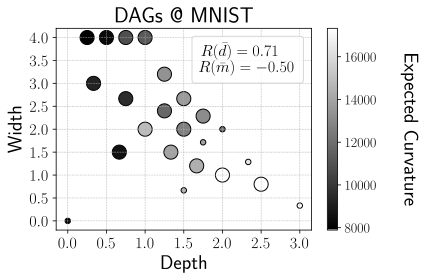

In [283]:
import scipy.stats as stats

# num_mlps = 3
X1 = []; X2 = []; Y = []
for idx, dag in enumerate(dags):
#     if dag[-1] == num_mlps:
        X1.append(dag[1])
        X2.append(dag[2])
        Y.append(LEs[idx].mean())


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2), 
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            s=np.clip(unrolled_data[:, 3]*10000, 30, 200),
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label(r"$\frac{\lambda_{\text{max}}}{\lambda_{\text{min}}}$", rotation=270, labelpad=30, fontsize=24)
# cbar.set_label("Expected Length Distortion", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Expected Curvature", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel("Depth", fontsize=20)
plt.ylabel("Width", fontsize=20)

plt.legend(handletextpad=-2, markerscale=0, fontsize=16)

plt.title("DAGs @ MNIST", fontsize=22)
plt.tight_layout()

# plt.savefig("LE_vs_depth_width.pdf")
# plt.savefig("LE_vs_depth_width_normalized.pdf")

In [22]:
depths_eff = np.array([dag[1] for dag in dags])
widths_eff = np.array([dag[2] for dag in dags])
widths = np.array([depth * width for depth, width in zip(depths_eff, widths_eff)])

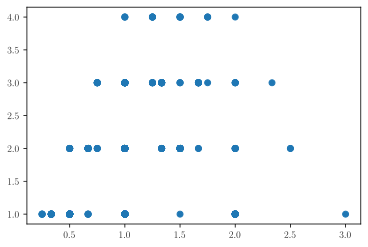

In [13]:
plt.scatter(depths_eff, widths)

## Bulk Training Results

In [886]:
idx = 26
print(dags[idx], np.mean(LEs[idx]), np.mean(kappas[idx]))
print(kappas[idx])
print(np.mean(kappas[idx]))

[list([[0], [0, 0], [2, 2, 2]]) 1.0 1 1] 0.1753852665424347 6012.739086914063
[5520.20159912 5949.01593018 6063.840271   6238.46563721 6292.17199707]
6012.739086914063


In [885]:
idx = 365
print(dags[idx], np.mean(LEs[idx]), np.mean(kappas[idx]))
print(kappas[idx])
print(np.mean(kappas[idx]))

[list([[1], [1, 1], [1, 1, 2]]) 0.5 4 1] 0.5050161957740784 2325.254574584961
[2232.80157471 2307.4916687  2349.00469971 2362.30427551 2374.6706543 ]
2325.254574584961


## Read Bulk Results

In [6]:
# root = "./experiment/BULK-cifar10-mlp16-LR0.0010000-BS128-Epoch6000-seed0"

root = "./experiment/BULK-tinyimagenet-mlp256-LR0.0050000-BS128-Epoch3000"

dag_ids = [_id for _id in os.listdir(root) if os.path.isdir(os.path.join(root, _id))]
dag_ids = [int(_id) for _id in dag_ids if not os.path.isfile(os.path.join(root, "%s.ing"%_id))]
print(len(dag_ids))

EPOCHS = 2999

409


In [7]:
def read_acc_from_log(lines, target_epoch=6000, delta_epoch=200):
    results = [0, -1, -1, -1]
    for line in lines:
        if line.startswith("Epoch"):
            _line = line.split()
            if len(_line) < 8: continue
            try:
                epoch, train_acc, valid_acc, test_acc = int(_line[1]), float(_line[3]), float(_line[5]), float(_line[7])
            except Exception:
                bp()
                epoch, train_acc, valid_acc, test_acc = int(_line[1]), float(_line[3]), float(_line[5]), float(_line[7])
            if abs(epoch - results[0]) < abs(target_epoch - results[0]):
                results = [epoch, train_acc, valid_acc, test_acc]
    if abs(results[0] - target_epoch) < delta_epoch:
        return results[1:]
    else:
        return None

In [ ]:
results = []
for _id in dag_ids:
    with open(os.path.join(root, str(_id), "seed-0.log")) as f:
        lines = f.readlines()
    _result = read_acc_from_log(lines, target_epoch=6000)
    if _result:
        results.append([_id, *_result])
results = np.array(results)
print(results.shape)

In [9]:
from tensorboard.backend.event_processing import event_accumulator

def read_from_tb(tb_dir, seeds=[''], test_name="test"):
    train_loss = {}
    train_accuracy = {}
    test_loss = {}
    test_accuracy = {}
    for seed in seeds:
        tbs = [name for name in os.listdir(os.path.join(tb_dir, str(seed))) if name.startswith("events")]
        for name in tbs:
            ea = event_accumulator.EventAccumulator(os.path.join(tb_dir, str(seed), name),
                size_guidance={ # see below regarding this argument
                event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                event_accumulator.IMAGES: 4,
                event_accumulator.AUDIO: 4,
                event_accumulator.SCALARS: 0,
                event_accumulator.HISTOGRAMS: 1,
            })
            ea.Reload()
            # ea.Tags()
            if not ('train/loss' in ea.Tags()['scalars'] and '%s/loss'%test_name in ea.Tags()['scalars']): continue
            for train_loss_item, train_accuracy_item, test_loss_item, test_accuracy_item in zip(ea.Scalars('train/loss'), ea.Scalars('train/accuracy'), ea.Scalars('%s/loss'%test_name), ea.Scalars('%s/accuracy'%test_name)):
                assert train_loss_item.step == test_loss_item.step, "step: train %d vs. test %d"%(train_item.step, test_item.step)
                step = train_loss_item.step
                if step in train_loss:
                    train_loss[step].append(train_loss_item.value)
                    train_accuracy[step].append(train_accuracy_item.value)
                    test_loss[step].append(test_loss_item.value)
                    test_accuracy[step].append(test_accuracy_item.value)
                else:
                    train_loss[step] = [train_loss_item.value]
                    train_accuracy[step] = [train_accuracy_item.value]
                    test_loss[step] = [test_loss_item.value]
                    test_accuracy[step] = [test_accuracy_item.value]
    steps = sorted(list(train_loss.keys()))
    # assert steps[-1] > 980 # TODO
    assert steps[-1] > EPOCHS-10, "%s: %d"%(tb_dir, steps[-1])
    train_loss = [np.mean(train_loss[step]) for step in steps]
    train_accuracy = [np.mean(train_accuracy[step]) for step in steps]
    test_loss = [np.mean(test_loss[step]) for step in steps]
    test_accuracy = [np.mean(test_accuracy[step]) for step in steps]
    return train_loss, train_accuracy, test_loss, test_accuracy, steps

In [10]:
train_loss_all = {}
train_accuracy_all = {}
test_loss_all = {}
test_accuracy_all = {}
steps_all = {}
# seeds = [0, 1, 2]
seeds = [0]
for _id in tqdm(dag_ids):
    train_loss, train_accuracy, test_loss, test_accuracy, steps = read_from_tb(os.path.join(root, str(_id)), seeds=seeds, test_name='validation')
    if train_loss:
        train_loss_all[_id] = train_loss
        train_accuracy_all[_id] = train_accuracy
        test_loss_all[_id] = test_loss
        test_accuracy_all[_id] = test_accuracy
        steps_all[_id] = steps
print(len(train_loss_all), len(test_loss_all))

100%|██████████| 409/409 [02:21<00:00,  2.89it/s]

409 409


### DAGs

In [38]:
root = "./experiment/TRAVERSAL-DAG/0501040951"

# root = "./experiment/TRAVERSAL-DAG-effective_width/0728001442"

dags = np.load(os.path.join(root, "dags_valid.npy"), allow_pickle=True)

print(dags.shape)

(729, 4)


### Convergence

In [1660]:
# corner case (very slow convergence)
# DAG#26
# DAG#365
idx = 26
print(dags[idx], np.mean(LEs[idx]), np.mean(kappas[idx]))
print(kappas[idx])
print(np.mean(kappas[idx]))

[list([[0], [0, 0], [2, 2, 2]]) 1.0 1 1] 0.1753852665424347 6012.739086914063
[5520.20159912 5949.01593018 6063.840271   6238.46563721 6292.17199707]
6012.739086914063


In [46]:
target_acc = 50

root = "./experiment/TRAVERSAL-NTK-tinyimagenet-mlp256.NoBias-BS128/seed821_0518205803"

# dags = np.load(os.path.join(root, "dags_valid.npy"), allow_pickle=True)
nngp_eigs = np.load(os.path.join(root, "nngp_eigs.npy"), allow_pickle=True)
ntk_eigs = np.load(os.path.join(root, "ntk_eigs.npy"), allow_pickle=True)

print(dags.shape, nngp_eigs.shape, ntk_eigs.shape)

(729, 4) (729, 5) (729, 5)


In [ ]:
convergence_all = {}
for idx in tqdm(dag_ids):
    if train_accuracy_all[idx][-1] < target_acc:
        convergence_all[idx] = EPOCHS
    else:
        convergence_all[idx] = steps_all[idx][np.where(np.array(train_accuracy_all[idx]) >= target_acc)[0][0]]
print(len(convergence_all))

304 304


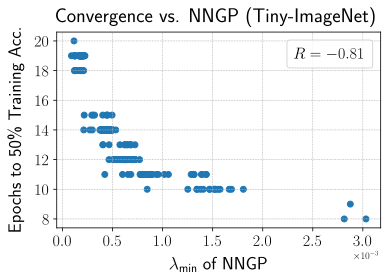

In [1823]:
import scipy.stats as stats

X = []; Y = []
num_mlps = -1

for idx in dag_ids:
    if num_mlps >= 0 and dags[idx][-1] < num_mlps: continue
    if nngp_eigs[idx][0] == -1: continue
    X.append(np.mean([eigs[0] for eigs in nngp_eigs[idx]])); xlabel = r"$\lambda_\text{min}$ of NNGP"
    Y.append(steps_all[idx][np.where(np.array(train_accuracy_all[idx]) >= target_acc)[0][0]]); ylabel = r"Epochs to %d\%% Training Acc."%target_acc

print(len(X), len(Y))
corr, p_value = stats.kendalltau(X, Y)

# fig = plt.figure(figsize=(5.5, 4))
fig, ax = plt.subplots(figsize=(5.5, 4))

plt.scatter(X, Y, label=r"$R=%.2f$"%corr)
plt.grid(linestyle='--', linewidth=0.5)
# plt.xlabel(r"Length Distorsion", fontsize=20)
plt.xlabel(xlabel, fontsize=18, labelpad=8)
# plt.ylabel(r"Train Accuracy", fontsize=20)
# plt.ylabel(r"Test Accuracy", fontsize=20)
plt.ylabel(ylabel, fontsize=18, labelpad=10)
# plt.ylabel(ylabel, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# cbar = plt.colorbar(format='%.0e')
# plt.gca().ticklabel_format(axis='x', style='sci', useOffset=False)

plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

plt.title("Convergence vs. NNGP (Tiny-ImageNet)", fontsize=20, pad=10, x=0.49)
plt.legend(handletextpad=-2, markerscale=0, fontsize=16)
plt.tight_layout()

# plt.savefig("epoch_nngp.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [0.3333333333333333, 0.5, 0.8, 1.0, 1.2, 1.2857142857142856, 1.3333333333333333, 1.5, 1.7999999999999998, 2.0, 2.25, 2.2857142857142856, 2.4, 2.6666666666666665, 3.0, 3.2, 4.0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


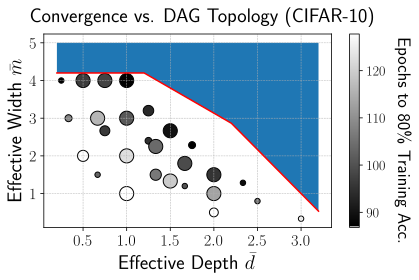

In [49]:
import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    X1.append(dags[int(idx)][1]) # depth
    X2.append(dags[int(idx)][2]) # width
    Y.append(steps_all[idx][np.where(np.array(train_accuracy_all[idx]) >= target_acc)[0][0]])


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            # s=np.clip(unrolled_data[:, 3]*30, 30, 200), # TinyImageNet
            # s=np.clip(unrolled_data[:, 3]*30, 30, 200), # CIFAR100
            s=np.clip(unrolled_data[:, 3]*100, 30, 200), # CIFAR10
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Epochs to %d\%% Training Acc."%target_acc, rotation=270, labelpad=25, fontsize=18, y=0.45)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

# plt.xlabel(r"Effective Depth $\bar{d}$", fontsize=20)
# plt.ylabel(r"Effective Width $\bar{m}$", fontsize=20)

plt.legend(handletextpad=-2, markerscale=0, fontsize=15, loc='best', bbox_to_anchor=(0.52, 0.48, 0.5, 0.5))


# ##############################################################################
# # depth-width pareto front on DAG
# precision = 0

# depths_round = np.round(depth_unique, precision).tolist()
# depths_round = list(set(depths_round))
# pareto = {_d: 0 for _d in depths_round} # depth: width
# for _d, _w in zip(X1, X2):
#     pareto[np.round(_d, precision)] = max(_w, pareto[np.round(_d, precision)])

# pareto_sorted = sorted(zip(list(pareto.keys()), list(pareto.values())), key=lambda pair: pair[0])
# # skips = [0, 1, 5]; keeps = [_i for _i in range(len(pareto_sorted)) if _i not in skips]; pareto_sorted = np.take(pareto_sorted, keeps, axis=0) ############### 201
# # offset = 0
# offset = 0.2 ############### 201
# plt.plot([_d + offset for _d, _ in pareto_sorted], [_w + offset for _, _w in pareto_sorted], '-', c='red')
# plt.fill_between([_d + offset for _d, _ in pareto_sorted], [_w + offset for _, _w in pareto_sorted], max(width_unique)+1)

# # DARTS: see below cells "Derived Single Path"
# ##############################################################################


# plt.title(r"Convergence vs. DAG Topology (Tiny-ImageNet)", fontsize=20, pad=12, x=0.55)
# plt.title(r"Convergence vs. DAG Topology (CIFAR-100)", fontsize=20, pad=12, x=0.55)
plt.title(r"Convergence vs. DAG Topology (CIFAR-10)", fontsize=20, pad=12, x=0.55)
plt.tight_layout()

# plt.savefig("epoch_depth_width_tinyimagenet.pdf")
# plt.savefig("epoch_depth_width_cifar100.pdf")
plt.savefig("epoch_depth_width_cifar10.pdf")
# plt.savefig("epoch_depth_effective_width_cifar10.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


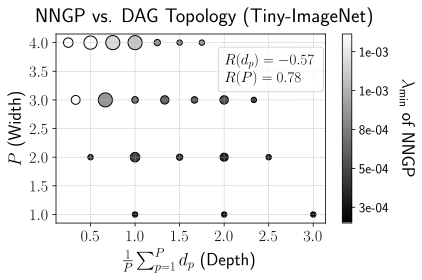

In [1741]:
import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    if nngp_eigs[idx][0] == -1: continue
    X1.append(dags[int(idx)][1])
    # X1.append(dags[int(idx)][1] * dags[int(idx)][2])
    X2.append(dags[int(idx)][2])
    Y.append(np.mean([eigs[0] for eigs in nngp_eigs[idx]]))


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            s=np.clip(unrolled_data[:, 3]*1000000, 30, 200),
)
plt.gray()
cbar = plt.colorbar(format='%.0e')
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label(r"$\lambda_\text{min}$ of NNGP", rotation=270, labelpad=25, fontsize=18)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)
# cbar.ax.ticklabel_format(style='sci',scilimits=(-3,4))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

plt.legend(handletextpad=-2, markerscale=0, fontsize=15, loc='best', bbox_to_anchor=(0.52, 0.47, 0.5, 0.5))

plt.title(r"NNGP vs. DAG Topology (Tiny-ImageNet)", fontsize=20, pad=12, x=0.55)
plt.tight_layout()

# plt.savefig("nngp_depth_width.pdf")

### Complexity

In [1859]:
root = "./experiment/TRAVERSAL-LENGTH-tinyimagenet-mlp256-BS128/seed854_0428051847"

# dags = np.load(os.path.join(root, "dags_valid.npy"), allow_pickle=True)
LEs = np.load(os.path.join(root, "LEs_all.npy"), allow_pickle=True)
kappas = np.load(os.path.join(root, "kappas_all.npy"), allow_pickle=True)

print(dags.shape, LEs.shape, kappas.shape)

(729, 4) (729, 5) (729, 5)


In [1860]:
converged = {}
for idx in dag_ids:
    train_loss = train_loss_all[idx]
    converged[idx] = np.mean(train_loss[-200:-180]) - np.mean(train_loss[-20:])

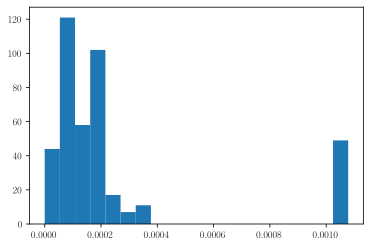

In [1828]:
_ = plt.hist(converged.values(), bins=20)

In [1745]:
def find_converged_epoch(losses, epsilon, step_delta=50, count=10):
    step = 0
    counter = 0
    while step + step_delta < len(losses):
        if abs(np.mean(losses[step:step+step_delta]) - np.mean(losses[step+step_delta:step+2*step_delta])) < epsilon:
            counter += 1
        else:
            counter = 0
        if counter >= count:
            return step - step_delta * (counter - 1)
        step += step_delta
    # assert step + step_delta < len(losses), "not converged!"
    return -1

In [1861]:
step_delta = 10; count = 10
converged_epoch = {}
for idx in tqdm(dag_ids):
    train_loss = train_loss_all[idx]
    converged_epoch[idx] = max(1375, find_converged_epoch(train_loss, 1e-4, step_delta=step_delta, count=count)) # TinyImageNet
    # converged_epoch[idx] = max(1000, find_converged_epoch(train_loss, 1e-3, step_delta=step_delta, count=count)) # CIFAR-100
    # converged_epoch[idx] = max(800, find_converged_epoch(train_loss, 1e-4, step_delta=step_delta, count=count)) # CIFAR-10

  0%|          | 0/729 [00:00<?, ?it/s]

(array([84., 95., 76., 87., 18.,  0.,  0.,  0.,  0., 49.]),
 array([ 800.,  964., 1128., 1292., 1456., 1620., 1784., 1948., 2112.,
        2276., 2440.]),
 <BarContainer object of 10 artists>)

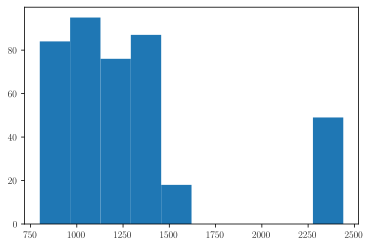

In [1840]:
plt.hist(converged_epoch.values())

In [1862]:
complexity_all = {}
for idx in tqdm(dag_ids):
    train_loss = train_loss_all[idx]
    complexity_all[idx] = np.round(np.mean(train_loss[converged_epoch[idx]:converged_epoch[idx]+step_delta]), decimals=5)
print(len(complexity_all))

  0%|          | 0/729 [00:00<?, ?it/s]

729


176 176


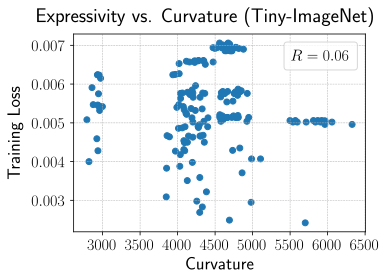

In [1834]:
import scipy.stats as stats

X = []; Y = []
num_mlps = 2

# for idx, train_loss, test_loss in zip(ids_valid, train_loss_all, test_loss_all):
for idx in dag_ids:
    # if num_mlps >= 0 and dags[idx][-1] != num_mlps: continue
    if num_mlps >= 0 and dags[idx][-1] < num_mlps: continue
    train_loss = train_loss_all[idx]
    test_loss = test_loss_all[idx]
    # if LEs[int(idx)].mean() < 0 or np.isnan(LEs[int(idx)].mean()): continue
    # X.append(LEs[int(idx)].mean()); xlabel = "Jacobian"
    if kappas[int(idx)].mean() < 0 or np.isnan(kappas[int(idx)].mean()): continue
    X.append(kappas[int(idx)].mean()); xlabel = "Curvature"
    # Y.append(train_loss[-1]); ylabel = r"Train Loss"
    # Y.append(np.round(np.mean(train_loss[-50:]), decimals=5)); ylabel = r"Train Loss"
    Y.append(complexity_all[idx]); ylabel = r"Training Loss"

print(len(X), len(Y))
corr, p_value = stats.kendalltau(X, Y)
# corr, p_value = stats.pearsonr(X, Y)

fig = plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, label=r"$R=%.2f$"%corr)

# plt.ylim([0.001, 0.0035])

plt.grid(linestyle='--', linewidth=0.5)
# plt.xlabel(r"Length Distorsion", fontsize=20)
plt.xlabel(xlabel, fontsize=18)
# plt.ylabel(r"Train Accuracy", fontsize=20)
# plt.ylabel(r"Test Accuracy", fontsize=20)
plt.ylabel(ylabel, fontsize=18, labelpad=8)
# plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Expressivity vs. Curvature (Tiny-ImageNet)", fontsize=20, pad=12, x=0.45)
plt.legend(handletextpad=-2, markerscale=0, fontsize=16)
plt.tight_layout()

# plt.savefig("train_loss_curvature.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


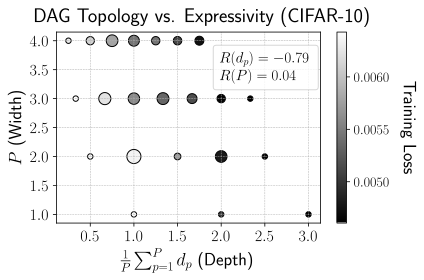

In [1851]:
import scipy.stats as stats

num_mlps = 1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    # if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if num_mlps >= 0 and dags[idx][-1] < num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    X1.append(dags[int(idx)][1])
    X2.append(dags[int(idx)][2])
    # Y.append(np.round(np.mean(train_loss_all[idx][-50:]), decimals=5))
    Y.append(complexity_all[idx])


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            # s=np.clip(unrolled_data[:, 3]*1000000, 30, 200), # TinyImageNet
            # s=np.clip(unrolled_data[:, 3]*100000, 30, 200), # CIFAR-100
            s=np.clip(unrolled_data[:, 3]*300000, 30, 200), # CIFAR-10
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Training Loss", rotation=270, labelpad=25, fontsize=18)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

plt.legend(handletextpad=-2, markerscale=0, fontsize=15, loc='best', bbox_to_anchor=(0.52, 0.47, 0.5, 0.5))

# plt.title("DAG Topology vs. Expressivity (Tiny-ImageNet)", fontsize=20, pad=10, x=0.55)
# plt.title("DAG Topology vs. Expressivity (CIFAR-100)", fontsize=20, pad=10, x=0.55)
plt.title("DAG Topology vs. Expressivity (CIFAR-10)", fontsize=20, pad=10, x=0.55)
plt.tight_layout()

# plt.savefig("train_loss_depth_width_tinyimagenet.pdf")
# plt.savefig("train_loss_depth_width_cifar100.pdf")
# plt.savefig("train_loss_depth_width_cifar10.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


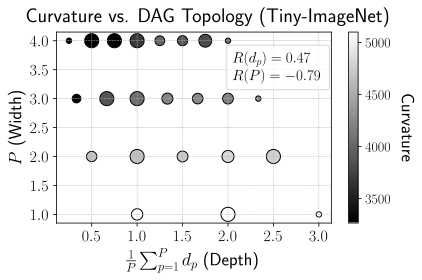

In [1643]:
import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    if kappas[int(idx)].mean() < 0 or np.isnan(kappas[int(idx)].mean()): continue
    X1.append(dags[int(idx)][1])
    X2.append(dags[int(idx)][2])
    Y.append(kappas[int(idx)].mean())


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            s=np.clip(unrolled_data[:, 3]*1, 30, 200),
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Curvature", rotation=270, labelpad=22, fontsize=18)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

plt.legend(handletextpad=-2, markerscale=0, loc='best', fontsize=15, bbox_to_anchor=(0.52, 0.47, 0.5, 0.5))

plt.title("Curvature vs. DAG Topology (Tiny-ImageNet)", fontsize=20, pad=10, x=0.55)
plt.tight_layout()

# plt.savefig("curvature_depth_width.pdf")

### Generalization

In [1863]:
generalization_all = {}
for idx in tqdm(dag_ids):
    # generalization_all[idx] = test_loss_all[idx][-1] - train_loss_all[idx][-1]
    # generalization_all[idx] = np.round(np.mean(test_loss_all[idx][converged_epoch[idx]:converged_epoch[idx]+step_delta]), decimals=5) - np.round(np.mean(train_loss_all[idx][converged_epoch[idx]:converged_epoch[idx]+step_delta]), decimals=5)
    generalization_all[idx] = np.round(test_loss_all[idx][converged_epoch[idx]], decimals=5) - np.round(train_loss_all[idx][converged_epoch[idx]], decimals=5)
print(len(generalization_all))

  0%|          | 0/729 [00:00<?, ?it/s]

729


In [1776]:
def find_eig_idx_cumsum(eigs, ratio=0.9):
    # return 0
    eigs_sorted = sorted(eigs)[::-1]
    eigs_sorted_sum = np.cumsum(eigs_sorted) / sum(eigs)
    return len(eigs_sorted) - np.where(eigs_sorted_sum >= 0.9)[0][0]

In [1777]:
find_eig_idx_cumsum(ntk_eigs[100][0])

31

176 176


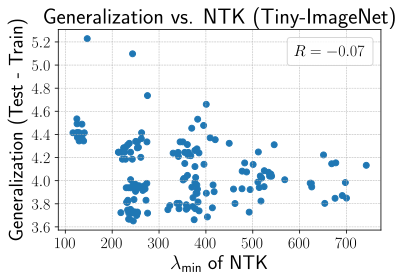

In [1837]:
import scipy.stats as stats

X = []; Y = []
num_mlps = 2

for idx in dag_ids:
    if num_mlps >= 0 and dags[idx][-1] < num_mlps: continue
    if nngp_eigs[idx][0] == -1: continue
    X.append(np.mean([eigs[find_eig_idx_cumsum(eigs)] for eigs in ntk_eigs[idx]])); xlabel = r"$\lambda_\text{min}$ of NTK"
    # X.append(np.mean([eigs[0] for eigs in ntk_eigs[idx]])); xlabel = r"$\lambda_\text{min}$ of NTK"
    # X.append(np.mean([eigs[64] for eigs in nngp_eigs[idx]])); xlabel = r"$\lambda_\text{min}$ of NTK"
    # Y.append(test_loss_all[idx][-1] - train_loss_all[idx][-1]); ylabel = r"Generalization (Test - Train)"
    Y.append(generalization_all[idx]); ylabel = r"Generalization (Test - Train)"
    # Y.append(generalization_all[idx]/dags[idx][1]); ylabel = r"Generalization (Test - Train)"

print(len(X), len(Y))
corr, p_value = stats.kendalltau(X, Y)

fig = plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, label=r"$R=%.2f$"%corr)
plt.grid(linestyle='--', linewidth=0.5)
# plt.xlabel(r"Length Distorsion", fontsize=20)
plt.xlabel(xlabel, fontsize=20)
# plt.ylabel(r"Train Accuracy", fontsize=20)
# plt.ylabel(r"Test Accuracy", fontsize=20)
plt.ylabel(ylabel, fontsize=20)
# plt.ylabel(ylabel, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Generalization vs. NTK (Tiny-ImageNet)", fontsize=22)
plt.legend(handletextpad=-2, markerscale=0, fontsize=16)
plt.tight_layout()

# plt.savefig("generalization_ntk.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


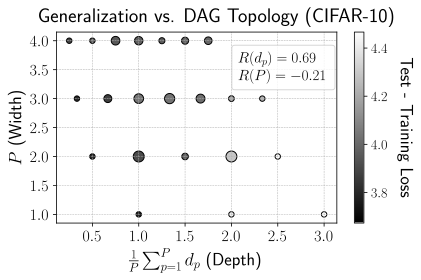

In [1846]:
import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    X1.append(dags[int(idx)][1])
    X2.append(dags[int(idx)][2])
    # Y.append(test_loss_all[idx][-1] - train_loss_all[idx][-1])
    Y.append(generalization_all[idx])


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - 1.5*np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + 1.5*np.std(unrolled_data[:, 2]),
            # s=np.clip(unrolled_data[:, 3]*200, 30, 200), # TinyImageNet
            # s=np.clip(unrolled_data[:, 3]*400, 30, 200), # CIFAR-100
            s=np.clip(unrolled_data[:, 3]*500, 30, 200), # CIFAR-10
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Test - Training Loss", rotation=270, labelpad=25, fontsize=18)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

plt.legend(handletextpad=-2, markerscale=0, loc='best', fontsize=15, bbox_to_anchor=(0.52, 0.47, 0.5, 0.5))

# plt.title("Generalization vs. DAG Topology (Tiny-ImageNet)", fontsize=20, pad=10, x=0.57)
# plt.title("Generalization vs. DAG Topology (CIFAR-100)", fontsize=20, pad=10, x=0.57)
plt.title("Generalization vs. DAG Topology (CIFAR-10)", fontsize=20, pad=10, x=0.57)
plt.tight_layout()

# plt.savefig("generalization_depth_width_tinyimagenet.pdf")
# plt.savefig("generalization_depth_width_cifar100.pdf")
# plt.savefig("generalization_depth_width_cifar10.pdf")

depth:  [0.25, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 1.0, 1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 1.75, 2.0, 2.3333333333333335, 2.5, 3.0]
width:  [1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


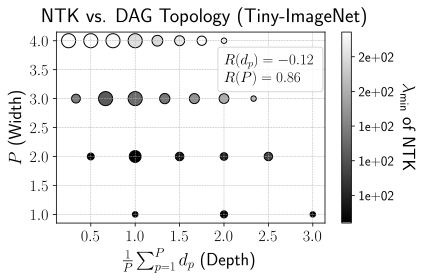

In [1632]:
import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []
for idx in dag_ids:
    if num_mlps >= 0 and dags[int(idx)][-1] != num_mlps: continue
    if dags[int(idx)][1] == 0: continue
    if nngp_eigs[idx][0] == -1: continue
    X1.append(dags[int(idx)][1])
    X2.append(dags[int(idx)][2])
    # Y.append(np.mean([eigs[0] for eigs in ntk_eigs[idx]]))
    Y.append(np.mean([eigs[find_eig_idx_cumsum(eigs)] for eigs in ntk_eigs[idx]]))


fig = plt.figure(figsize=(6, 4))

plt.grid(linestyle='--', linewidth=0.5)


depth_unique = sorted(list(set(X1)))
width_unique = sorted(list(set(X2)))
print("depth: ", depth_unique)
print("width: ", width_unique)
merged_data = np.zeros((len(depth_unique), len(width_unique)))
merged_std = {_d: {_w: [] for _w in width_unique} for _d in depth_unique}
counter = np.zeros((len(depth_unique), len(width_unique)))
for _d, _w, _v in zip(X1, X2, Y):
    idx_d = depth_unique.index(_d)
    idx_w = width_unique.index(_w)
    merged_data[idx_d, idx_w] += _v
    merged_std[_d][_w].append(_v)
    counter[idx_d, idx_w] += 1
merged_data /= counter
unrolled_data = []
for i, _d in enumerate(depth_unique):
    for j, _w in enumerate(width_unique):
        if np.isnan(merged_data[i, j]): continue
        # if len(merged_std[_d][_w]) < 3: continue # at lease three samples for stable std
        unrolled_data.append([depth_unique[i], width_unique[j], merged_data[i, j], np.std(merged_std[_d][_w])])
unrolled_data = np.array(unrolled_data)

corr1, p_value = stats.kendalltau(unrolled_data[:, 0], unrolled_data[:, 2])
corr2, p_value = stats.kendalltau(unrolled_data[:, 1], unrolled_data[:, 2])

plt.scatter(unrolled_data[:, 0], unrolled_data[:, 1], edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(d_p)=%.2f$"%corr1 + "\n" + "$R(P)=%.2f$"%corr2,
            c=unrolled_data[:, 2],
            vmin=np.mean(unrolled_data[:, 2]) - np.std(unrolled_data[:, 2]), vmax=np.mean(unrolled_data[:, 2]) + np.std(unrolled_data[:, 2]),
            s=np.clip(unrolled_data[:, 3]*10, 30, 200),
)
plt.gray()
cbar = plt.colorbar(format='%.0e')
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label(r"$\lambda_\text{min}$ of NTK", rotation=270, labelpad=20, fontsize=18)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"$\frac{1}{P} \sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.ylabel(r"$P$ (Width)", fontsize=18)

plt.legend(handletextpad=-2, markerscale=0, loc='best', fontsize=15, bbox_to_anchor=(0.52, 0.46, 0.5, 0.5))

plt.title("NTK vs. DAG Topology (Tiny-ImageNet)", fontsize=20, pad=10, x=0.55)
plt.tight_layout()

# plt.savefig("ntk_depth_width.pdf")

## Ranking Comparison

In [1065]:
def binarySearch(array, x):
    low = 0
    high = len(array) - 1
    while low <= high:
        mid = low + (high - low)//2
        if array[mid] == x:
            return mid
        elif array[mid] < x:
            low = mid # array[low] must < x
        else:
            high = mid # array[high] must > x
        if high - low <= 1:
            if array[low] == x:
                return low
            elif array[high] == x:
                return high
            elif array[low] > x: # x < array[low]
                return low
            elif array[high] < x: # x > array[high]
                return high + 1
            else: # in between low and high
                return low + 1


def sequential_search(array, x):
    if array[0] > x: return 1
    if array[-1] < x: return len(array) + 1
    index = 0
    while array[index] < x:
        index += 1
        continue
    return index + 1


def get_rank(value, pool, ascending=True):
    pool_sorted = list(pool)
    pool_sorted = sorted(pool_sorted, reverse=not ascending)
    # index = binarySearch(pool_sorted, value)
    index = sequential_search(pool_sorted, value)
    return index # + 1 # ranking from 1


def get_ranks_teg(t, e, g, Ts, Es, Gs):
    rank_t = get_rank(t, Ts)
    rank_e = get_rank(e, Es)
    rank_g = get_rank(g, Gs)
    return rank_t, rank_e, rank_g

In [1864]:
best_ranks = [math.inf, math.inf, math.inf]
best_idx = None
for _idx in range(len(dags)):
    if _idx in convergence_all:
        ranks = get_ranks_teg(convergence_all[_idx], complexity_all[_idx], generalization_all[_idx], list(convergence_all.values()), list(complexity_all.values()), list(generalization_all.values()))
        if sum(ranks) < sum(best_ranks):
            best_ranks = list(ranks)
            best_idx = _idx
print(best_idx, dags[best_idx])
print(best_ranks, sum(best_ranks))
print(train_loss_all[best_idx][-1], train_accuracy_all[best_idx][-1], test_loss_all[best_idx][-1], test_accuracy_all[best_idx][-1])

727 [list([[2], [2, 2], [2, 2, 1]]) 1.5 4 5]
[107, 71, 188] 366
0.000803826202172786 100.0 17.737916946411133 4.599999904632568


In [1865]:
sum([1 if dags[idx][1] <= 0 else 0 for idx in range(len(dags))])

188

In [1866]:
from collections import OrderedDict

ranks_all = OrderedDict()
for _idx in range(len(dags)):
    if dags[_idx][1] <= 0: continue
    ranks = get_ranks_teg(
        convergence_all[_idx], complexity_all[_idx], generalization_all[_idx],
        # list(convergence_all.values()),
        list({k: v for k, v in convergence_all.items() if dags[k][1] > 0}.values()),
        # list(complexity_all.values()),
        list({k: v for k, v in complexity_all.items() if dags[k][1] > 0}.values()),
        # list(generalization_all.values())
        list({k: v for k, v in generalization_all.items() if dags[k][1] > 0}.values()),
    )
    ranks_all[_idx] = ranks
# ranks_all = np.array(ranks_all)
ranks_all_array = np.array(list(ranks_all.values()))
print(len(ranks_all_array))

K = 3
print("topk by sum of ranks")
# topk = np.argsort(np.sum(ranks_all, axis=1))[:K]
topk = OrderedDict(sorted(ranks_all.items(), key=lambda x: x[1][0]+x[1][1]+x[1][2]))
for idx, ranks in list(topk.items())[:K]:
    print(idx, dags[idx], ranks, sum(ranks))
    # print(_idx, dags[_idx], ranks_all[_id], sum(ranks_all[_id]), "%.4f"%train_loss_all[_idx][-1], "%.4f"%train_accuracy_all[_idx][-1], "%.4f"%test_loss_all[_idx][-1], "%.4f"%test_accuracy_all[_idx][-1])

print("topk by convergence")
# topk = np.argsort([ranks_all[_idx, 0] if dags[rank_idx_all[_idx]][1] > 0 else math.inf for _idx in range(len(ranks_all))])[:K]
topk = OrderedDict(sorted(ranks_all.items(), key=lambda x: x[1][0]))
for idx, ranks in list(topk.items())[:K]:
    print(idx, dags[idx], ranks, sum(ranks))
    # print(_idx, dags[_idx], ranks_all[_id], sum(ranks_all[_id]), "%.4f"%train_loss_all[_idx][-1], "%.4f"%train_accuracy_all[_idx][-1], "%.4f"%test_loss_all[_idx][-1], "%.4f"%test_accuracy_all[_idx][-1])

print("topk by generalization")
# topk = np.argsort([ranks_all[_idx, 2] if dags[rank_idx_all[_idx]][1] > 0 else math.inf for _idx in range(len(ranks_all))])[:K]
topk = OrderedDict(sorted(ranks_all.items(), key=lambda x: x[1][2]))
for idx, ranks in list(topk.items())[:K]:
    print(idx, dags[idx], ranks, sum(ranks))
    # print(_idx, dags[_idx], ranks_all[_id], sum(ranks_all[_id]), "%.4f"%train_loss_all[_idx][-1], "%.4f"%train_accuracy_all[_idx][-1], "%.4f"%test_loss_all[_idx][-1], "%.4f"%test_accuracy_all[_idx][-1])

print("topk by convergence + generalization")
# topk = np.argsort([ranks_all[_idx, 0]+ranks_all[_idx, 2] if dags[rank_idx_all[_idx]][1] > 0 else math.inf for _idx in range(len(ranks_all))])[:K]
topk = OrderedDict(sorted(ranks_all.items(), key=lambda x: x[1][0]+x[1][2]))
for idx, ranks in list(topk.items())[:K]:
    print(idx, dags[idx], ranks, sum(ranks))
    # print(_idx, dags[_idx], ranks_all[_id], sum(ranks_all[_id]), "%.4f"%train_loss_all[_idx][-1], "%.4f"%train_accuracy_all[_idx][-1], "%.4f"%test_loss_all[_idx][-1], "%.4f"%test_accuracy_all[_idx][-1])

print("topk by complexity")
# topk = np.argsort([ranks_all[_idx, 1] if dags[rank_idx_all[_idx]][1] > 0 else math.inf for _idx in range(len(ranks_all))])[:K]
topk = OrderedDict(sorted(ranks_all.items(), key=lambda x: x[1][1]))
for idx, ranks in list(topk.items())[:K]:
    print(idx, dags[idx], ranks, sum(ranks))
    # print(_idx, dags[_idx], ranks_all[_id], sum(ranks_all[_id]), "%.4f"%train_loss_all[_idx][-1], "%.4f"%train_accuracy_all[_idx][-1], "%.4f"%test_loss_all[_idx][-1], "%.4f"%test_accuracy_all[_idx][-1])

541
topk by sum of ranks
727 [list([[2], [2, 2], [2, 2, 1]]) 1.5 4 5] (76, 71, 5) 152
701 [list([[2], [2, 1], [2, 2, 2]]) 1.75 4 5] (105, 54, 18) 177
698 [list([[2], [2, 1], [2, 1, 2]]) 1.5 4 4] (105, 78, 17) 200
topk by convergence
367 [list([[1], [1, 1], [1, 2, 1]]) 0.25 4 1] (1, 541, 494) 1036
373 [list([[1], [1, 1], [2, 1, 1]]) 0.25 4 1] (1, 324, 497) 822
376 [list([[1], [1, 1], [2, 2, 1]]) 0.5 4 2] (1, 252, 238) 491
topk by generalization
484 [list([[1], [2, 2], [2, 2, 1]]) 1.0 4 4] (39, 217, 1) 257
671 [list([[2], [2, 0], [2, 1, 2]]) 1.3333333333333333 3 4] (105, 190, 2) 297
350 [list([[1], [1, 0], [2, 2, 2]]) 1.0 3 3] (76, 239, 3) 318
topk by convergence + generalization
484 [list([[1], [2, 2], [2, 2, 1]]) 1.0 4 4] (39, 217, 1) 257
403 [list([[1], [1, 2], [2, 2, 1]]) 0.75 4 3] (39, 222, 21) 282
319 [list([[1], [0, 2], [2, 1, 1]]) 0.6666666666666666 3 2] (46, 301, 25) 372
topk by complexity
542 [list([[2], [0, 2], [0, 0, 2]]) 3.0 1 3] (538, 1, 541) 1080
545 [list([[2], [0, 2], [0

In [1922]:
WIDTHS = 256
root = "./experiment"

In [1923]:
train_loss_ablation = {}
train_accuracy_ablation = {}
test_loss_ablation = {}
test_accuracy_ablation = {}
steps_ablation = {}

In [1924]:
path2pruning_lora = {
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.3_0.5-Epoch3000/seed144_0513May051652456224/": (WIDTHS, 0.3, 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.2_0.5-Epoch3000/seed27_0513May051652456218/": (WIDTHS, 0.2, 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.1_0.5-Epoch3000/seed996_0513May051652456212/": (WIDTHS, 0.1, 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.0_0.5-Epoch3000/seed468_0513May051652456204/": (WIDTHS, 0., 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.4_0.5-Epoch3000/seed84_0522May051653276073/": (WIDTHS, 0.4, 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.4_0.3-Epoch3000/seed754_0512May051652392604/": (WIDTHS, 0.4, 0.3),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.4_0.2-Epoch3000/seed217_0512May051652392598/": (WIDTHS, 0.4, 0.2),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.4_0.1-Epoch3000/seed234_0512May051652392592/": (WIDTHS, 0.4, 0.1),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.4_0.0-Epoch3000/seed830_0512May051652392570/": (WIDTHS, 0.4, 0.),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.3_0.0-Epoch3000/seed312_0512May051652414096/": (WIDTHS, 0.3, 0.),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.2_0.0-Epoch3000/seed100_0512May051652414089/": (WIDTHS, 0.2, 0.),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.1_0.0-Epoch3000/seed788_0512May051652414073/": (WIDTHS, 0.1, 0.),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.0_0.3-Epoch3000/seed138_0512May051652414038/": (WIDTHS, 0., 0.3),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.3_0.2-Epoch3000/seed99_0512May051652413662/": (WIDTHS, 0.3, 0.2),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.3_0.1-Epoch3000/seed735_0512May051652413659/": (WIDTHS, 0.3, 0.1),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.2_0.3-Epoch3000/seed501_0512May051652413654/": (WIDTHS, 0.2, 0.3),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.2_0.1-Epoch3000/seed35_0512May051652413648/": (WIDTHS, 0.2, 0.1),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.1_0.3-Epoch3000/seed212_0512May051652413643/": (WIDTHS, 0.1, 0.3),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.1_0.2-Epoch3000/seed899_0512May051652413637/": (WIDTHS, 0.1, 0.2),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.0_0.2-Epoch3000/seed621_0512May051652392380/": (WIDTHS, 0., 0.2),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.0_0.1-Epoch3000/seed353_0512May051652392371/": (WIDTHS, 0., 0.1),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.3_0.4-Epoch3000/seed307_0512May051652392273/": (WIDTHS, 0.3, 0.4),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.2_0.4-Epoch3000/seed650_0512May051652392270/": (WIDTHS, 0.2, 0.4),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.1_0.4-Epoch3000/seed486_0512May051652392265/": (WIDTHS, 0.1, 0.4),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.0_0.4-Epoch3000/seed174_0512May051652392246/": (WIDTHS, 0., 0.4),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.90-Epoch3000/seed543_0510May051652223590/": (WIDTHS, 0.9),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.80-Epoch3000/seed133_0510May051652223587/": (WIDTHS, 0.8),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.70-Epoch3000/seed852_0510May051652223581/": (WIDTHS, 0.7),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.60-Epoch3000/seed654_0510May051652223574/": (WIDTHS, 0.6),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.50-Epoch3000/seed99_0510May051652201951/": (WIDTHS, 0.5),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.40-Epoch3000/seed767_0510May051652201940/": (WIDTHS, 0.4),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.30-Epoch3000/seed741_0510May051652201931/": (WIDTHS, 0.3),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.20-Epoch3000/seed267_0510May051652201924/": (WIDTHS, 0.2),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-prune0.10-Epoch3000/seed933_0510May051652201918/": (WIDTHS, 0.1),
    "tinyimagenet-mlp256_1_22_221-2_02_002-share_edgeFalse-supernetTrue-separated_readoutFalse-LR0.0050000-BS128-Epoch3000/seed195_0510May051652201912/": (WIDTHS, 0.),
}


In [1925]:
for path, key in tqdm(path2pruning_lora.items()):
    train_loss, train_accuracy, test_loss, test_accuracy, steps = read_from_tb(os.path.join(root, path), test_name='validation')
    if train_loss:
        train_loss_ablation[key] = train_loss
        train_accuracy_ablation[key] = train_accuracy
        test_loss_ablation[key] = test_loss
        test_accuracy_ablation[key] = test_accuracy
        steps_ablation[key] = steps
print(len(train_loss_ablation), len(test_loss_ablation))
print(train_loss_ablation.keys())

  0%|          | 0/35 [00:00<?, ?it/s]

35 35
dict_keys([(256, 0.3, 0.5), (256, 0.2, 0.5), (256, 0.1, 0.5), (256, 0.0, 0.5), (256, 0.4, 0.5), (256, 0.4, 0.3), (256, 0.4, 0.2), (256, 0.4, 0.1), (256, 0.4, 0.0), (256, 0.3, 0.0), (256, 0.2, 0.0), (256, 0.1, 0.0), (256, 0.0, 0.3), (256, 0.3, 0.2), (256, 0.3, 0.1), (256, 0.2, 0.3), (256, 0.2, 0.1), (256, 0.1, 0.3), (256, 0.1, 0.2), (256, 0.0, 0.2), (256, 0.0, 0.1), (256, 0.3, 0.4), (256, 0.2, 0.4), (256, 0.1, 0.4), (256, 0.0, 0.4), (256, 0.9), (256, 0.8), (256, 0.7), (256, 0.6), (256, 0.5), (256, 0.4), (256, 0.3), (256, 0.2), (256, 0.1), (256, 0.0)])


In [1926]:
convergence_ablation = {}
for path, key in tqdm(path2pruning_lora.items()):
    if train_accuracy_ablation[key][-1] < target_acc:
        convergence_ablation[key] = EPOCHS
    else:
        convergence_ablation[key] = steps_ablation[key][np.where(np.array(train_accuracy_ablation[key]) >= target_acc)[0][0]]
print(len(convergence_ablation))

  0%|          | 0/35 [00:00<?, ?it/s]

35


In [1927]:
converged_epoch_ensembles = {}
for path, key in tqdm(path2pruning_lora.items()):
    train_loss = train_loss_ablation[key]
    converged_epoch_ensembles[key] = max(1375, find_converged_epoch(train_loss, 1e-4, step_delta=step_delta, count=count))

  0%|          | 0/35 [00:00<?, ?it/s]

In [1928]:
complexity_ablation = {}
for path, key in tqdm(path2pruning_lora.items()):
    # complexity_ablation[(_prune, _lora)] = train_loss_ablation[(_prune, _lora)][-1]
    train_loss = train_loss_ablation[key]
    complexity_ablation[key] = np.round(np.mean(train_loss[converged_epoch_ensembles[key]:converged_epoch_ensembles[key]+step_delta]), decimals=5)
print(len(complexity_ablation))

  0%|          | 0/35 [00:00<?, ?it/s]

35


In [1929]:
generalization_ablation = {}
for path, key in tqdm(path2pruning_lora.items()):
    # generalization_ablation[(_prune, _lora)] = test_loss_ablation[(_prune, _lora)][-1] - train_loss_ablation[(_prune, _lora)][-1]
    generalization_ablation[key] = np.round(test_loss_ablation[key][converged_epoch_ensembles[key]], decimals=5) - np.round(train_loss_ablation[key][converged_epoch_ensembles[key]], decimals=5)
print(len(generalization_ablation))

  0%|          | 0/35 [00:00<?, ?it/s]

35


In [1930]:
ranks_ablation = {}
for path, key in tqdm(path2pruning_lora.items()):
    # ranks = get_ranks_teg(convergence_ablation[key], complexity_ablation[key], generalization_ablation[key], list(convergence_all.values()), list(complexity_all.values()), list(generalization_all.values()))
    ranks = get_ranks_teg(
        convergence_ablation[key], complexity_ablation[key], generalization_ablation[key],
        # list(convergence_all.values()),
        list({k: v for k, v in convergence_all.items() if dags[k][1] > 0}.values()),
        # list(complexity_all.values()),
        list({k: v for k, v in complexity_all.items() if dags[k][1] > 0}.values()),
        # list(generalization_all.values())
        list({k: v for k, v in generalization_all.items() if dags[k][1] > 0}.values()),
    )
    ranks_ablation[key] = ranks
    print(key, ranks, sum(ranks))

  0%|          | 0/35 [00:00<?, ?it/s]

(256, 0.3, 0.5) (76, 32, 53) 161
(256, 0.2, 0.5) (39, 32, 38) 109
(256, 0.1, 0.5) (39, 32, 85) 156
(256, 0.0, 0.5) (39, 35, 85) 159
(256, 0.4, 0.5) (76, 40, 203) 319
(256, 0.4, 0.3) (76, 15, 222) 313
(256, 0.4, 0.2) (46, 11, 178) 235
(256, 0.4, 0.1) (46, 9, 228) 283
(256, 0.4, 0.0) (76, 12, 202) 290
(256, 0.3, 0.0) (46, 5, 128) 179
(256, 0.2, 0.0) (76, 9, 59) 144
(256, 0.1, 0.0) (46, 5, 73) 124
(256, 0.0, 0.3) (46, 11, 151) 208
(256, 0.3, 0.2) (46, 5, 180) 231
(256, 0.3, 0.1) (46, 11, 222) 279
(256, 0.2, 0.3) (46, 13, 40) 99
(256, 0.2, 0.1) (39, 11, 74) 124
(256, 0.1, 0.3) (46, 11, 79) 136
(256, 0.1, 0.2) (39, 9, 85) 133
(256, 0.0, 0.2) (39, 11, 179) 229
(256, 0.0, 0.1) (46, 11, 87) 144
(256, 0.3, 0.4) (46, 20, 203) 269
(256, 0.2, 0.4) (46, 32, 102) 180
(256, 0.1, 0.4) (46, 15, 86) 147
(256, 0.0, 0.4) (46, 15, 27) 88
(256, 0.9) (540, 243, 492) 1275
(256, 0.8) (386, 202, 486) 1074
(256, 0.7) (148, 77, 403) 628
(256, 0.6) (105, 56, 280) 441
(256, 0.5) (76, 50, 250) 376
(256, 0.4) (46, 13

In [1932]:
PARAM1 = 0.26
PARAM2 = 0.2
prune_ratios1 = [0., 0.1, 0.2, 0.3, 0.4]
prune_ratios2 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]

  0%|          | 0/35 [00:00<?, ?it/s]

0.44680989496394335 -0.06218501447092094


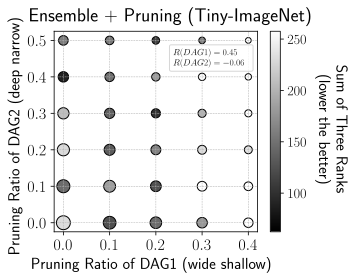

In [1933]:
# plt.scatter(range(len(prune_ratios1)), range(len(prune_ratios2)), ranks_matrix)

import scipy.stats as stats

num_mlps = -1

X1 = []; X2 = []; Y = []; Z = []

for key, rank in tqdm(ranks_ablation.items()):
    if len(key) == 3:
        prune1 = float(key[1])
        prune2 = float(key[2])
    else:
        prune1 = float(key[1])
        prune2 = prune1
    if prune1 > prune_ratios1[-1] or prune2 > prune_ratios2[-1]: continue
    X1.append(prune1)
    X2.append(prune2)
    Y.append(sum(rank))
    Z.append(PARAM1 * (1 - prune1) + PARAM2 * (1 - prune2))


fig = plt.figure(figsize=(5, 4))

plt.grid(linestyle='--', linewidth=0.5)

corr1, p_value = stats.kendalltau(X1, Y)
corr2, p_value = stats.kendalltau(X2, Y)
print(corr1, corr2)

plt.scatter(X1, X2, edgecolors='black',
            # label=r"$R(\bar{d})=%.2f\\R(\bar{m})=%.2f$"%(corr1, corr2),
            label=r"$R(DAG1)=%.2f$"%corr1 + "\n" + "$R(DAG2)=%.2f$"%corr2,
            c=Y,
            vmin=np.mean(Y) - 2.*np.std(Y), vmax=np.mean(Y) + 1.*np.std(Y),
            # vmin=min(Y), vmax=max(Y),
            s=np.clip(np.array(Z)**3*2000, 30, 200), # TinyImageNet
)
plt.gray()
cbar = plt.colorbar()
# cbar.set_label("Train Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.set_label("Sum of Three Ranks\n(lower the better)", rotation=270, labelpad=40, fontsize=16)
# cbar.set_label("Test Accuracy", rotation=270, labelpad=40, fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlabel(r"$\sum_{p=1}^P d_p$ (Depth)", fontsize=18)
plt.xlabel(r"Pruning Ratio of DAG1 (wide shallow)", fontsize=16)
plt.ylabel(r"Pruning Ratio of DAG2 (deep narrow)", fontsize=16)

plt.legend(handletextpad=-2, markerscale=0, loc='best', fontsize=9, bbox_to_anchor=(0.5, 0.455, 0.5, 0.5))

plt.title("Ensemble + Pruning (Tiny-ImageNet)", fontsize=19, pad=10, x=0.57)
plt.tight_layout()

plt.savefig("ensemble_pruning_tinyimagenet.pdf")